In [1]:
# import geomloss
import numpy as np
import sys
# import torch
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

sys.path.append("..") 

from data import get_database_path, get_h5_files, read_h5_file
from emd import emd_pot, sep_emd
import emd
from visualize import plot_event_cloud, plot_optimal_transport
from utils import load_toml_config

np.random.seed(114514)

In [2]:
import importlib
importlib.reload(emd)
from emd import emd_pot, sep_emd

In [3]:
# SM processes
files = load_toml_config("file")
database_path = get_database_path()
bkg_files, sig_files = get_h5_files()

print(files.keys())
bkg = read_h5_file(database_path, files["SM"])


dict_keys(['SM', 'neutral_boson', 'leptoquark', 'neutral_Higgs', 'charged_Higgs'])


In [4]:
import torch
import geomloss

a, b = torch.randn((100)), torch.randn((100))
x, y = torch.randn((100, 2)), torch.randn((100, 2))
p = 1
entreg = .1 # entropy regularization factor for Sinkhorn

# 若以欧式距离为metric，则cost function可以直接用geomloss提供的
# Sinkhorn快速解
OTLoss = geomloss.SamplesLoss(
    loss='sinkhorn', p=p,
    # 对于p=1或p=2的情形
    cost=geomloss.utils.distances if p==1 else geomloss.utils.squared_distances,
    blur=0.0001, backend='tensorized')
pW = OTLoss(a, x, b, y)
print(pW.item())

48.611183166503906


In [5]:
def process_events_torch(events):
    pts = events[:, 0]
    coords = events[:, 1:3]
    return torch.as_tensor(pts), torch.as_tensor(coords)

In [6]:
random_index = np.random.randint(len(bkg))
random_source_event = bkg[random_index]
random_target_event = bkg[random_index+1]

source_pts, source_coords = process_events_torch(random_source_event)
target_pts, target_coords = process_events_torch(random_target_event)
geomloss_emd = OTLoss(source_pts, source_coords, target_pts, target_coords)

emd = emd_pot(random_source_event, random_target_event)
print(geomloss_emd.item() - emd)


500.3791369631002


0.0


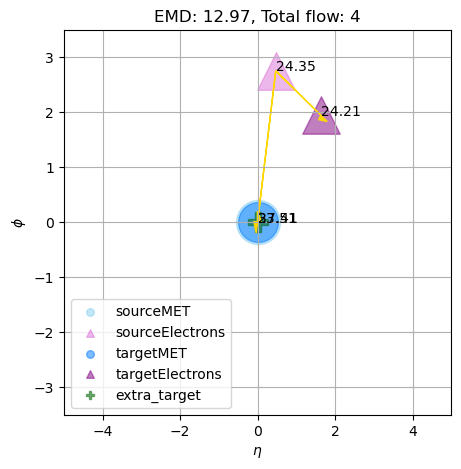

In [13]:
test_target_event = bkg[0]
test_source_event = bkg[1]
emd, flow_matrix = emd_pot(test_source_event, test_target_event, return_flow=True)
print(sep_emd(test_source_event, test_target_event) - emd)
plot_optimal_transport(test_source_event, test_target_event, flow_matrix, emd)

In [14]:
# print(test_source_event)
# print(test_target_event)
print(sep_emd(test_source_event, test_target_event))

12.971146199068858


In [15]:
EMD_config = load_toml_config('EMD')
particle_type_scale = EMD_config['particle_type_scale']
pair = EMD_config['n_pair']
norm = EMD_config['norm']
particle_one_hot = EMD_config['particle_one_hot']
pid_method=EMD_config['pid_method']

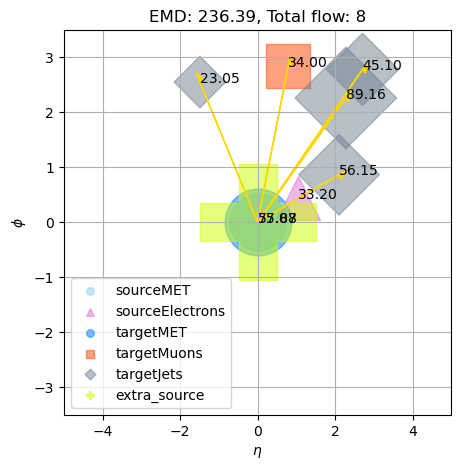

301.8593444824219


In [31]:
test_target_event = bkg[np.random.randint(0, len(bkg))]
test_source_event = bkg[np.random.randint(0, len(bkg))]
emd, flow_matrix = emd_pot(test_source_event, test_target_event, return_flow=True, particle_type_scale=particle_type_scale, norm=norm, particle_one_hot=particle_one_hot)
plot_optimal_transport(test_source_event, test_target_event, flow_matrix, emd)
print(sep_emd(test_source_event, test_target_event))

In [26]:
import importlib
import visualize
importlib.reload(visualize)
from visualize import plot_separate_optimal_transport

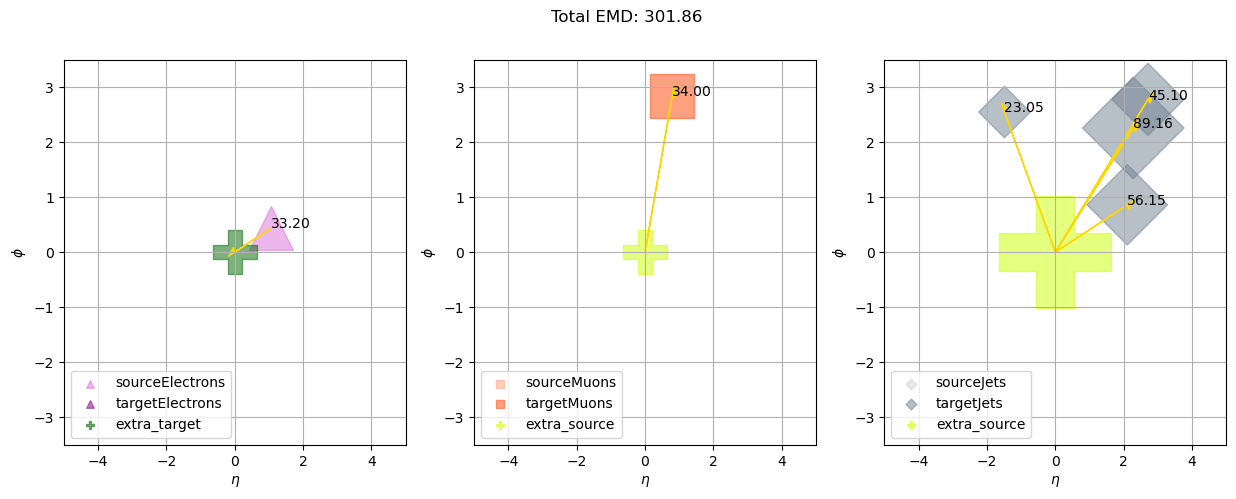

In [32]:
emd, e_matrix, mu_matrix, jet_matrix = sep_emd(test_source_event, test_target_event, return_flow=True)
plot_separate_optimal_transport(test_source_event, test_target_event, e_matrix, mu_matrix, jet_matrix, emd)